# lib

In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

# preprocessing data

In [2]:
import pandas_ta as ta

In [45]:
path_to_file = "btc.csv"

In [68]:
btc = pd.read_csv(path_to_file, skiprows=1)
btc = btc[::-1]
# btc = btc[2100:]
btc = btc.astype({'date': 'datetime64'}).set_index('date')
btc = btc.drop(['unix', 'symbol','Volume USD'], axis=1)

btc.head()

,open,high,low,close,Volume BTC
date,,,,,
2014-11-28,363.59,381.34,360.57,376.28,3220878.18
2014-11-29,376.42,386.60,372.25,376.72,2746157.05
2014-11-30,376.57,381.99,373.32,373.34,1145566.61
2014-12-01,376.40,382.31,373.03,378.39,2520662.37
2014-12-02,378.39,382.86,375.23,379.25,2593576.46


<AxesSubplot:title={'center':'Bitcoin Weighted Price'}, xlabel='date'>

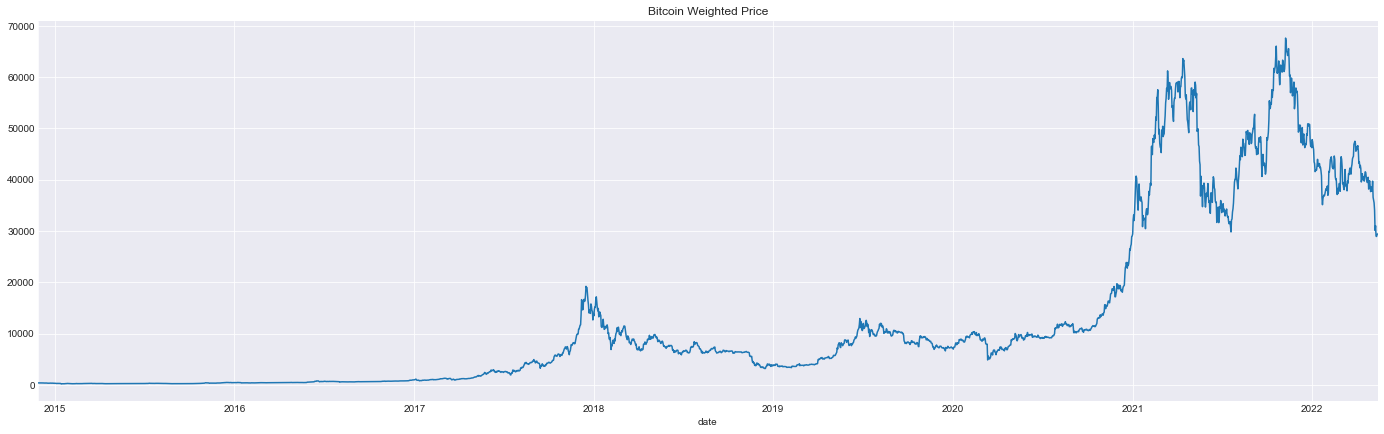

In [69]:
# btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")
btc.close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

In [70]:

btc['close_log'] =  np.log(btc['close'])
btc['diff1_log'] = btc['close_log'].diff()
btc['diff7_log'] = btc['close_log'].diff(7)
btc['diff30_log'] = btc['close_log'].diff(30)
btc['diff1'] = btc['close'].diff()
btc['diff7'] = btc['close'].diff(7)
btc['diff30'] = btc['close'].diff(30)
# btc['reverse_diff'] = btc['close'].shift(1) + btc['diff']
btc['rsi'] = ta.rsi(btc['close'],length=14)
btc['mom'] = ta.mom(btc['close'],length=10)
btc['target_log'] = btc['close_log'].shift(-1)
btc['target'] = btc['close'].shift(-1)
btc = btc.dropna()

In [71]:
btc.tail()

,open,high,low,close,Volume BTC,close_log,diff1_log,diff7_log,diff30_log,diff1,diff7,diff30,rsi,mom,target_log,target
date,,,,,,,,,,,,,,,,
2022-05-09,34051.20,34224.35,30015.00,30082.00,7631.121662,10.311682,-0.123183,-0.247277,-0.351861,-3943.50,-8439.01,-12685.89,24.506606,-8511.42,10.341742,30999.97
2022-05-10,30066.48,32650.00,29731.03,30999.97,7402.302313,10.341742,0.030059,-0.196468,-0.306865,917.97,-6729.98,-11133.88,28.604810,-6639.83,10.275051,29000.00
2022-05-11,31002.27,32148.15,27757.77,29000.00,11180.848836,10.275051,-0.066690,-0.313683,-0.309634,-1999.97,-10685.23,-10524.86,25.373064,-9488.34,10.271465,28896.19
2022-05-12,28999.99,30090.70,25401.05,28896.19,16578.810599,10.271465,-0.003586,-0.234532,-0.327603,-103.81,-7637.74,-11201.27,25.213830,-9624.82,10.283252,29238.81
2022-05-13,28932.69,30974.60,28686.37,29238.81,6010.273639,10.283252,0.011787,-0.208556,-0.341672,342.62,-6780.41,-11908.93,26.845615,-8491.14,10.288993,29407.14


In [72]:
prediction_days = 60

df_train_= btc[:][:len(btc)-prediction_days]#values.reshape(-1,1)

df_test_= btc[:][len(btc)-prediction_days:]#.values.reshape(-1,1)

# creat data lstm

In [73]:
df_train_.columns

Index(['open', 'high', 'low', 'close', 'Volume BTC', 'close_log', 'diff1_log',
       'diff7_log', 'diff30_log', 'diff1', 'diff7', 'diff30', 'rsi', 'mom',
       'target_log', 'target'],
      dtype='object')

In [74]:
df_train = df_train_[:][['open', 'high', 'low', 'close', 'Volume BTC', 'target']]
df_test = df_test_[:][['open', 'high', 'low', 'close', 'Volume BTC', 'target']]
df_test.head(2)

,open,high,low,close,Volume BTC,target
date,,,,,,
2022-03-15,39688.55,39896.13,38142.35,39302.70,1638.684030,41142.76
2022-03-16,39302.80,41693.97,38865.67,41142.76,5987.103889,40963.22


In [77]:
def scl(df):
    q = df[0]
    dq = []
    for i in range(len(df)):
        dq.append(q)
    df = (np.array(df) / np.array(dq)) - 1
    return df, q

In [97]:
# many to one

look_back_ = 5

from collections import deque
def dataset_generator_lstm(dataset, look_back=look_back_):
    sequential_data = [] 
    prev_days = deque(maxlen=look_back)
    for i in dataset.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == look_back:  
            prev_days_, q = scl(prev_days)
            target = i[-1] / q[3]
            sequential_data.append([np.array(prev_days_), target])
    dataX=[]
    dataY=[]
    for seq, target in sequential_data: 
        dataX.append(seq) 
        dataY.append(target) 
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(df_train)
trainX, trainY = trainX[2100:], trainY[2100:]
testX, testY = dataset_generator_lstm(df_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testY: ", testX.shape)
print("testY", testY.shape)

trainX:  (530, 5, 5)
trainY:  (530,)
testY:  (56, 5, 5)
testY (56,)


In [98]:
# many to one

look_back_ = 5

from collections import deque
def dataset_generator_lstm(dataset, look_back=look_back_):
    sequential_data = [] 
    prev_days = deque(maxlen=look_back)
    for i in dataset.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == look_back:  
            target = i[-1]
            sequential_data.append([np.array(prev_days), target])
    dataX=[]
    dataY=[]
    for seq, target in sequential_data: 
        dataX.append(seq) 
        dataY.append(target) 
    return np.array(dataX), np.array(dataY)

trainX__, trainY__ = dataset_generator_lstm(df_train)
trainX__, trainY__ = trainX__[2100:], trainY__[2100:]
testX__, testY__ = dataset_generator_lstm(df_test)

print("trainX: ", trainX__.shape)
print("trainY: ", trainY__.shape)
print("testY: ", testX__.shape)
print("testY", testY__.shape)

trainX:  (530, 5, 5)
trainY:  (530,)
testY:  (56, 5, 5)
testY (56,)


# train

In [99]:
regressor = Sequential()

regressor.add(LSTM(units = 256,return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
# 

regressor.add(LSTM(units = 128, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))

regressor.add(Dropout(0.2))


regressor.add(Dense(units = 1))

regressor.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 5, 256)            268288    
                                                                 
 dropout_10 (Dropout)        (None, 5, 256)            0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 465,537
Trainable params: 465,537
Non-trainable params: 0
_________________________________________________________________


In [100]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [101]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

history = regressor.fit(trainX, trainY, batch_size = 128, epochs = 3000, verbose=1, shuffle=False,
                        validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/3000
3/5 [=================>............] - ETA: 0s - loss: 1.0058 
Epoch 1: loss improved from inf to 0.94296, saving model to my_best_model.hdf5
5/5 [==============================] - 4s 186ms/step - loss: 0.9430 - val_loss: 0.6342
Epoch 2/3000
3/5 [=================>............] - ETA: 0s - loss: 0.6668
Epoch 2: loss improved from 0.94296 to 0.60987, saving model to my_best_model.hdf5
5/5 [==============================] - 0s 39ms/step - loss: 0.6099 - val_loss: 0.6023
Epoch 3/3000
4/5 [=======================>......] - ETA: 0s - loss: 0.2856
Epoch 3: loss improved from 0.60987 to 0.27873, saving model to my_best_model.hdf5
5/5 [==============================] - 0s 37ms/step - loss: 0.2787 - val_loss: 0.1336
Epoch 4/3000
3/5 [=================>............] - ETA: 0s - loss: 0.0385
Epoch 4: loss improved from 0.27873 to 0.03056, saving model to my_best_model.hdf5
5/5 [==============================] - 0s 34ms/step - loss: 0.0306 - val_loss: 0.0304
Epoch 5/3000
3/5 [========

3/5 [=================>............] - ETA: 0s - loss: 0.0066
Epoch 38: loss did not improve from 0.00595
5/5 [==============================] - 0s 33ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 39/3000
3/5 [=================>............] - ETA: 0s - loss: 0.0066
Epoch 39: loss did not improve from 0.00595
5/5 [==============================] - 0s 34ms/step - loss: 0.0062 - val_loss: 0.0019
Epoch 40/3000
3/5 [=================>............] - ETA: 0s - loss: 0.0069
Epoch 40: loss did not improve from 0.00595
5/5 [==============================] - 0s 33ms/step - loss: 0.0064 - val_loss: 0.0025
Epoch 41/3000
3/5 [=================>............] - ETA: 0s - loss: 0.0064
Epoch 41: loss improved from 0.00595 to 0.00588, saving model to my_best_model.hdf5
5/5 [==============================] - 0s 38ms/step - loss: 0.0059 - val_loss: 0.0018
Epoch 42/3000
3/5 [=================>............] - ETA: 0s - loss: 0.0073
Epoch 42: loss did not improve from 0.00588
5/5 [=========================

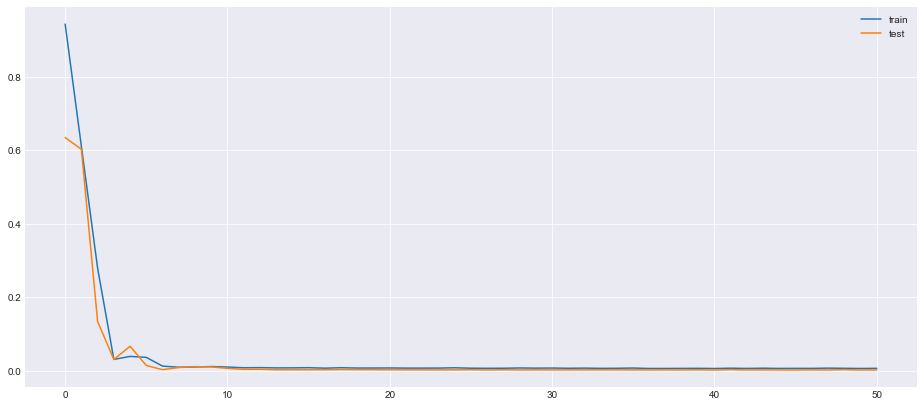

In [102]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [103]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model('my_best_model.hdf5')

# test test

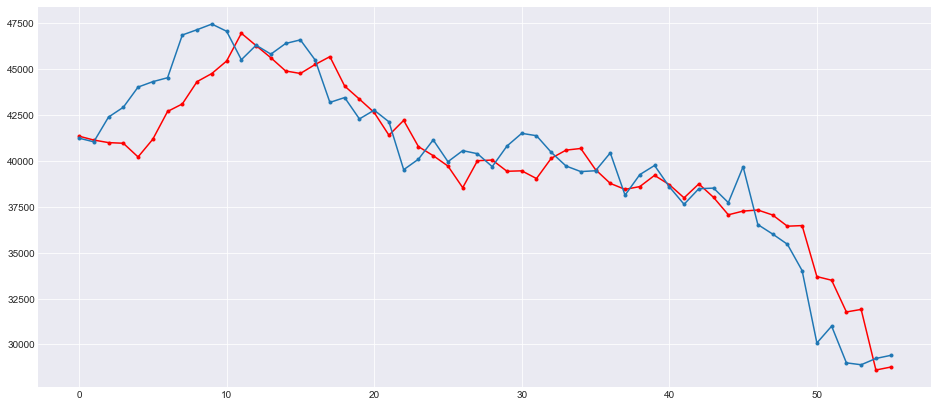

In [104]:
plt.figure(figsize=(16,7))

predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
testY_ = testY.copy()

for i in range(len(predicted_btc_price_test_data)):
    predicted_btc_price_test_data[i] = ((predicted_btc_price_test_data[i] * testX__[i][0][3]) )
    testY_[i] = ((testY[i] * testX__[i][0][3]))
    
plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(testY_, marker='.', label='Actual Test')

# test train

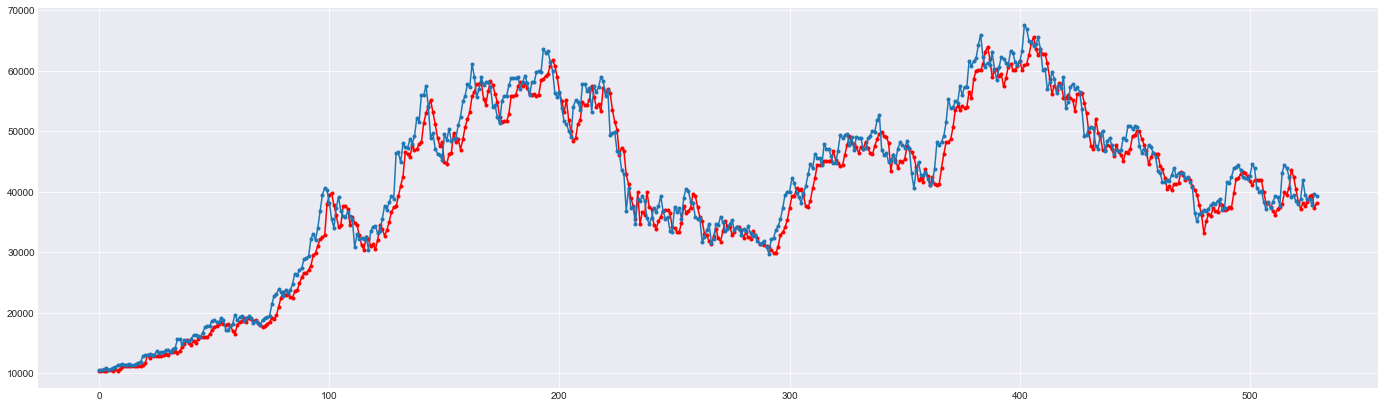

In [105]:
plt.figure(figsize=(24,7))

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
trainY_ =trainY.copy()

for i in range(len(predicted_btc_price_train_data)):
    predicted_btc_price_train_data[i] = predicted_btc_price_train_data[i] * trainX__[i][0][3]
    trainY_[i] = trainY[i] * trainX__[i][0][3]


plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Test')
plt.plot(trainY_, marker='.', label='Actual Test')